# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import ipywidgets as widgets

from matplotlib_venn import venn2sy




# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules TROR IKKE AT DET HER ER NØDVENDIGT LISE
import dataproject

# Installing pandas datareader
#%pip install pandas-datareader
import pandas_datareader # install with `pip install pandas-datareader`
import pandas_datareader.data as web
import datetime as dt



# Read and clean data

In [2]:


start_time = dt.datetime(2020,1,1)
end_time = dt.datetime(2020,1,1)

#Fetching "Pension at a Glance" (PAG) dataset for 2020
pag = web.DataReader('PAG', 'oecd',start_time, end_time)

pag = pag.T.reset_index() #Transposing rows and columns

pag.columns.name = None #Removing name from index row


# List of variables to keep
indicators_to_keep = ['Effective labour market exit age, men', 'Effective labour market exit age, women']

# Filter rows such that we keep wanted variables
pag = pag.loc[pag['Indicator'].isin(indicators_to_keep)]


pag.head()


,Country,Indicator,2020-01-01 00:00:00
46,Australia,"Effective labour market exit age, men",64.1
47,Australia,"Effective labour market exit age, women",63.1
114,Austria,"Effective labour market exit age, men",61.6
115,Austria,"Effective labour market exit age, women",60.1
182,Belgium,"Effective labour market exit age, men",60.4


In [3]:
# Renaming last column
pag.rename(columns={pag.columns[-1]: 'Unit'}, inplace=True)

# Printing unique countries for inspection
countries = pag['Country'].unique()

# Create list of EU countries. We do this because we want to calculate the means in EU.
EU_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Republic of Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# Filter dataframe such that we only keep EU countries.
pag_eu = pag[pag['Country'].isin(EU_countries)]

# Grouping dataframe by market retirement age for men and women and calculate the mean to get the EU mean exit age.
eu_mean_exit_age_men = pag_eu.loc[pag_eu['Indicator'] == 'Effective labour market exit age, men'].groupby('Indicator')['Unit'].mean().reset_index()
eu_mean_exit_age_women = pag_eu.loc[pag_eu['Indicator'] == 'Effective labour market exit age, women'].groupby('Indicator')['Unit'].mean().reset_index()
# Appending the calculated means
eu_mean_exit_age = pd.concat([eu_mean_exit_age_men, eu_mean_exit_age_women])

print(eu_mean_exit_age)


                                 Indicator    Unit
0    Effective labour market exit age, men  62.256
0  Effective labour market exit age, women  61.216


We see that the average age of labour market exit in the EU is 62.26 for men and 61.22 for women

**Merge**

In [4]:
# Merging our pag dataset with the created dataframe contain the EU means. The merge is a m:1
pag_merged = pd.merge(pag, eu_mean_exit_age, on='Indicator', how='left')

#Renaming columns

pag_merged.rename(columns={pag_merged.columns[2]: 'age'}, inplace=True)
pag_merged.rename(columns={pag_merged.columns[3]: 'eu_mean'}, inplace=True)
pag_merged

# Filtering out countries of interest: Denmark, France, Germany, Sweden, UK, Greece

countries_of_interest = ['Denmark','France','Germany', 'Sweden', 'United Kingdom']

pag_final = pag_merged[pag_merged['Country'].isin(countries_of_interest)]




**Creating plot of effective labour market exit for men and women in each country**

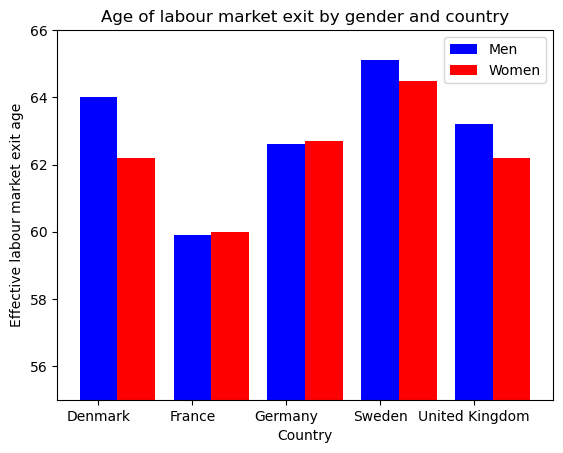

In [8]:


# Transforming data such that 'Effective labour market exit age, men' and 'Effective labour market exit age, women' have their own columns. This is done to create the bar charts later.
pag_pivot = pag_final.pivot_table(index='Country', columns='Indicator', values='age').reset_index()

# Setting bar width
bar_width = 0.4

# Generating sequence of x-values to determine x-coordinates
x_values = np.arange(len(pag_pivot['Country']))



# Creating figure and axis objects
fig, ax = plt.subplots()

ax.bar(x_values, pag_pivot['Effective labour market exit age, men'], label='Men', color='b', width=bar_width)
ax.bar(x_values + bar_width, pag_pivot['Effective labour market exit age, women'], label='Women', color='r', width=bar_width) #Adding bar_width such they don't overlap
ax.set_xticks(x_values)
ax.set_xticklabels(pag_pivot['Country'])
ax.set_xlabel('Country')
ax.set_ylabel('Effective labour market exit age')
ax.set_title('Age of labour market exit by gender and country')
ax.legend()

# Setting y-axis range
ax.set_ylim([55, 66])

plt.show()



We see that France has the lowest effective age of labour market exit while Sweden and Denmark have the highest.

**Demeaning ages**


We now want to demean the ages to see how much the retirement ages differ from the EU mean

In [11]:

# Demean for men and women
pag_final['age_demeaned'] = pag_final.age-pag_final.eu_mean


/var/folders/sf/sxm8_0k95c3cbxbg_3_hjh0h0000gn/T/ipykernel_58808/702759376.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pag_final['age_demeaned'] = pag_final.age-pag_final.eu_mean


Plot of demeaned age

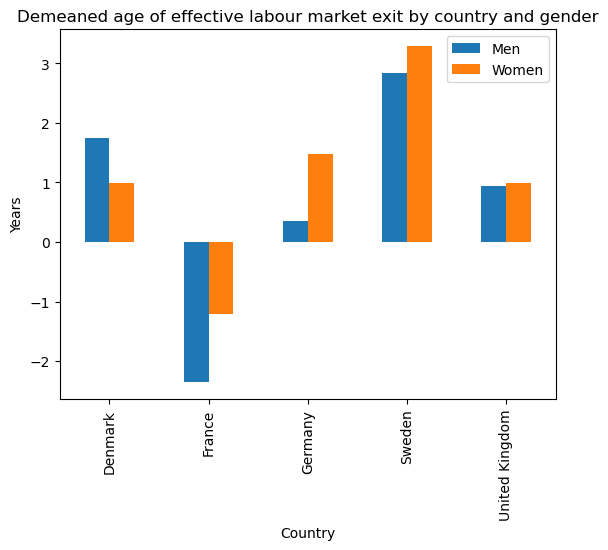

In [18]:

# We now pivot the data such that we the data grouped by country as index and the demeaned ages for men and women as columns.
pag_pivot_2 = pd.pivot_table(pag_final, values='age_demeaned', index=['Country'], columns=['Indicator'])
# Renaming columns and index in new dataframe
pag_pivot_2.columns = ['age_demeaned_men', 'age_demeaned_women']


# Plottin pivot table
ax = pag_pivot_2.plot(kind='bar')
ax.set_title('Demeaned age of effective labour market exit by country and gender')
ax.set_xlabel('Country')
ax.set_ylabel('Years')
ax.legend(labels=['Men', 'Women'])
plt.show()

In the above plot we see that the age of labour market exit is above the EU means for all countries but France.